In [1]:
# Note: this notebook was designed with the Roboto Condensed font, which can be installed here: https://www.1001fonts.com/roboto-condensed-font.html

from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
''')

# Data Cleaning

In [48]:
import pandas as pd
import geopandas as gpd
from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import MultiPolygon
import matplotlib.pyplot as plt
import json
import requests
import seaborn as sns
import scipy as sp

### SA2 Regions

In [3]:
sa2 = gpd.read_file('data/sa2/SA2_2021_AUST_GDA2020.shp')

# Find and remove null values
sa2['geometry'].isnull().values.any()

sa2 = sa2[~sa2['geometry'].isna()]

# Make the column names lower case
sa2.columns = map(str.lower, sa2.columns)

# Drop unnecessary columns
sa2 = sa2.drop('chg_flag21', axis=1)
sa2 = sa2.drop('chg_lbl21', axis=1)
sa2 = sa2.drop('sa3_code21', axis=1)
sa2 = sa2.drop('sa3_name21', axis=1)
sa2 = sa2.drop('sa4_code21', axis=1)
sa2 = sa2.drop('sa4_name21', axis=1)
sa2 = sa2.drop('ste_code21', axis=1)
sa2 = sa2.drop('ste_name21', axis=1)
sa2 = sa2.drop('aus_code21', axis=1)
sa2 = sa2.drop('aus_name21', axis=1)
sa2 = sa2.drop('loci_uri21', axis=1)
sa2 = sa2.drop('areasqkm21', axis=1)

# Convert polygon to multipolygon
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

sa2og = sa2.copy()
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4283))
sa2 = sa2.drop(columns="geometry")

### Population

In [4]:
population = pd.read_csv('data/population.csv')

# Find any null values
population['total_people'].isnull().values.any()

# Remove unnecessary columns
population = population.drop('20-24_people', axis=1)
population = population.drop('25-29_people', axis=1)
population = population.drop('30-34_people', axis=1)
population = population.drop('35-39_people', axis=1)
population = population.drop('40-44_people', axis=1)
population = population.drop('45-49_people', axis=1)
population = population.drop('50-54_people', axis=1)
population = population.drop('55-59_people', axis=1)
population = population.drop('60-64_people', axis=1)
population = population.drop('65-69_people', axis=1)
population = population.drop('70-74_people', axis=1)
population = population.drop('75-79_people', axis=1)
population = population.drop('80-84_people', axis=1)
population = population.drop('85-and-over_people', axis=1)

# Create column 'young_people'
column_names = ['0-4_people', '5-9_people', '10-14_people', '15-19_people']
population['young_people'] = population[column_names].sum(axis=1)

# Drop the columns with the individual age groups
population = population.drop('0-4_people', axis=1)
population = population.drop('5-9_people', axis=1)
population = population.drop('10-14_people', axis=1)
population = population.drop('15-19_people', axis=1)

### Businesses

In [5]:
businesses = pd.read_csv('data/businesses.csv')

businesses['industry_name'].unique()

array(['Agriculture, Forestry and Fishing', 'Mining', 'Manufacturing',
       'Electricity, Gas, Water and Waste Services', 'Construction',
       'Wholesale Trade', 'Retail Trade',
       'Accommodation and Food Services',
       'Transport, Postal and Warehousing',
       'Information Media and Telecommunications',
       'Financial and Insurance Services',
       'Rental, Hiring and Real Estate Services',
       'Professional, Scientific and Technical Services',
       'Administrative and Support Services',
       'Public Administration and Safety', 'Education and Training',
       'Health Care and Social Assistance',
       'Arts and Recreation Services', 'Other Services'], dtype=object)

In [6]:
businesses = pd.read_csv('data/businesses.csv')

# Select the relevant industries
businesses['industry_name'].unique()

industries_to_include = ['Accommodation and Food Services', 
                         'Retail Trade', 'Arts and Recreation Services', 
                         'Professional, Scientific and Technical Services',
                         'Education and Training',
                         'Health Care and Social Assistance']

businesses = businesses[businesses['industry_name'].isin(industries_to_include)]

# Check the data types
businesses.dtypes

# Find and remove any null values
businesses.isnull().any()

businesses['sa2_name']

businesses = businesses[~businesses['sa2_name'].isin(['Currently Unknown'])]

businesses['industry_code'].unique()

# Drop unnecessary rows

businesses = businesses.drop('0_to_50k_businesses', axis=1)
businesses = businesses.drop('50k_to_200k_businesses', axis=1)
businesses = businesses.drop('200k_to_2m_businesses', axis=1)
businesses = businesses.drop('2m_to_5m_businesses', axis=1)
businesses = businesses.drop('5m_to_10m_businesses', axis=1)
businesses = businesses.drop('10m_or_more_businesses', axis=1)

### Stops

In [7]:
stops = pd.read_csv('data/stops.csv')

# Check the data types
stops.dtypes

# Find and remove any null values
stops['stop_lat'].isnull().values.any()
stops['stop_lon'].isnull().values.any()

# Drop unnecessary columns
stops = stops.drop('stop_code', axis=1)
stops = stops.drop('location_type', axis=1)
stops = stops.drop('parent_station', axis=1)
stops = stops.drop('wheelchair_boarding', axis=1)
stops = stops.drop('platform_code', axis=1)

# Transform latitude/longitude to point and remove latitude/longitude
### According to the source, WGS84 is used, hence srid = 4283
stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)

stops = stops.drop(columns=['stop_lat', 'stop_lon'])

stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=4283))

### Polling Places

In [8]:
pollingplaces2019 = pd.read_csv('data/pollingplaces2019.csv')

# Check the data types
pollingplaces2019.dtypes

# Find and remove any null values
pollingplaces2019['latitude'].isnull().values.any()
pollingplaces2019['longitude'].isnull().values.any()

pollingplaces2019 = pollingplaces2019[~pollingplaces2019['latitude'].isna()]
pollingplaces2019 = pollingplaces2019[~pollingplaces2019['longitude'].isna()]

# Drop unnecessary columns
pollingplaces2019 = pollingplaces2019.drop('FID', axis=1)
pollingplaces2019 = pollingplaces2019.drop('state', axis=1)
pollingplaces2019 = pollingplaces2019.drop('division_id', axis=1)
pollingplaces2019 = pollingplaces2019.drop('division_name', axis=1)
pollingplaces2019 = pollingplaces2019.drop('polling_place_type_id', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_address_2', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_address_3', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_state_abbreviation', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_post_code', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_suburb', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_address_1', axis=1)
pollingplaces2019 = pollingplaces2019.drop('premises_name', axis=1)
pollingplaces2019 = pollingplaces2019.drop('the_geom', axis=1)

# Convert latitude/longitude to a point

pollingplaces2019['geom'] = gpd.points_from_xy(pollingplaces2019.longitude, pollingplaces2019.latitude)

pollingplaces2019 = pollingplaces2019.drop(columns=['latitude', 'longitude'])

pollingplaces2019['geom'] = pollingplaces2019['geom'].apply(lambda x: WKTElement(x.wkt, srid=4283))

### Catchments

In [9]:
#read in files
primary = gpd.read_file('data/catchments/catchments_primary.shp')
secondary = gpd.read_file('data/catchments/catchments_secondary.shp')

#create column to denote school type
primary['school_type'] = 'PRIMARY'
secondary['school_type'] = 'SECONDARY'

#combine tables together
catchments = pd.concat([primary, secondary])

#ensure no null values in geometry
catchments['geometry'].isnull().values.any()

#remove unnecessary columns
catchments = catchments.drop('ADD_DATE', axis=1)
catchments = catchments.drop('PRIORITY', axis=1)
catchments = catchments.drop('KINDERGART', axis=1)
catchments = catchments.drop('YEAR1', axis=1)
catchments = catchments.drop('YEAR2', axis=1)
catchments = catchments.drop('YEAR3', axis=1)
catchments = catchments.drop('YEAR4', axis=1)
catchments = catchments.drop('YEAR5', axis=1)
catchments = catchments.drop('YEAR6', axis=1)
catchments = catchments.drop('YEAR7', axis=1)
catchments = catchments.drop('YEAR8', axis=1)
catchments = catchments.drop('YEAR9', axis=1)
catchments = catchments.drop('YEAR10', axis=1)
catchments = catchments.drop('YEAR11', axis=1)
catchments = catchments.drop('YEAR12', axis=1)

# Make the column names lower case
catchments.columns = map(str.lower, catchments.columns)

# Convert polygon to multipolygon
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

catch2og = catchments.copy()
catchments['geom'] = catchments['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4283))
catchments = catchments.drop('geometry', axis=1)

### Alcohol Licenses

In [10]:
alcohollicenses = pd.read_csv('data/alcohollicenses.csv', encoding='latin-1')

alcohollicenses

# Find and remove any null values
alcohollicenses['Latitude'].isnull().values.any()
alcohollicenses['Longitude'].isnull().values.any()

alcohollicenses = alcohollicenses[~alcohollicenses['Latitude'].isna()]
alcohollicenses = alcohollicenses[~alcohollicenses['Longitude'].isna()]

# Drop any unnecessary columns
alcohollicenses = alcohollicenses.drop('Licence Type', axis=1)
alcohollicenses = alcohollicenses.drop('Status', axis=1)
alcohollicenses = alcohollicenses.drop('Start Date', axis=1)
alcohollicenses = alcohollicenses.drop('Address', axis=1)
alcohollicenses = alcohollicenses.drop('Suburb', axis=1)
alcohollicenses = alcohollicenses.drop('Postcode', axis=1)
alcohollicenses = alcohollicenses.drop('LGA', axis=1)
alcohollicenses = alcohollicenses.drop('Precinct', axis=1)
alcohollicenses = alcohollicenses.drop('Licensee Name', axis=1)
alcohollicenses = alcohollicenses.drop('Business Type Name', axis=1)
alcohollicenses = alcohollicenses.drop('Authorisation/Restriction Name', axis=1)
alcohollicenses = alcohollicenses.drop('Extended Trading', axis=1)
alcohollicenses = alcohollicenses.drop('Reduced Trading', axis=1)
alcohollicenses = alcohollicenses.drop('Primary Service', axis=1)
alcohollicenses = alcohollicenses.drop('Right to Keep Gaming', axis=1)
alcohollicenses = alcohollicenses.drop('Unrestricted Trading Hours', axis=1)
alcohollicenses = alcohollicenses.drop('After 12am', axis=1)
alcohollicenses = alcohollicenses.drop('After 3am', axis=1)
alcohollicenses = alcohollicenses.drop('After 5am', axis=1)
alcohollicenses = alcohollicenses.drop('SA2', axis=1)
alcohollicenses = alcohollicenses.drop('Band', axis=1)
alcohollicenses = alcohollicenses.drop('GMEs', axis=1)
alcohollicenses = alcohollicenses.drop('PMPs', axis=1)
alcohollicenses = alcohollicenses.drop('Auth Limit', axis=1)
alcohollicenses = alcohollicenses.drop('Unfld Quota', axis=1)
alcohollicenses = alcohollicenses.drop('GMT', axis=1)
alcohollicenses = alcohollicenses.drop('EGMs', axis=1)

# Convert latitude/longitude to a point
alcohollicenses['geom'] = gpd.points_from_xy(alcohollicenses.Longitude, alcohollicenses.Latitude)

alcohollicenses = alcohollicenses.drop(columns=['Latitude', 'Longitude'])

alcohollicenses['geom'] = alcohollicenses['geom'].apply(lambda x: WKTElement(x.wkt, srid=4283))

# Rename columns
alcohollicenses = alcohollicenses.rename(columns={'Licence No.': 'license_no', 'Licence Name': 'license_name', 'geom': 'geom'})

### Air Quality

In [11]:
stations = json.loads(requests.get('https://data.airquality.nsw.gov.au/api/Data/get_SiteDetails').text)
aq_stations = pd.DataFrame(stations)
aq_stations['geom'] = gpd.points_from_xy(aq_stations.Longitude, aq_stations.Latitude)
aq_stations = aq_stations.dropna()
aq_stations.columns = map(str.lower, aq_stations.columns)

In [12]:
#read in json
aq = open('data/responsev2.json', 'r')
airquality = ""
airquality += aq.readline()
aq.close()
airq = json.loads(airquality)
qual = pd.json_normalize(airq)

#Drop unnecessary columns
qual = qual.drop('AirQualityCategory', axis=1)
qual = qual.drop('DeterminingPollutant', axis=1)
qual = qual.drop('Parameter.ParameterDescription', axis=1)
qual = qual.drop('Parameter.Units', axis=1)
qual = qual.drop('Parameter.UnitsDescription', axis=1)
qual = qual.drop('Parameter.Category', axis=1)
qual = qual.drop('Parameter.SubCategory', axis=1)
qual = qual.drop('Parameter.Frequency', axis=1)
qual = qual.drop('Parameter.ParameterCode', axis=1)
qual = qual.drop('Hour', axis=1)
qual = qual.drop('Date', axis=1)
qual = qual.drop('HourDescription', axis=1)

#colnames to lower case
qual.columns = map(str.lower, qual.columns)


#removes only 1 line from Newcastle - outside our bounds
qual.dropna(inplace=True)

#Group by Site ID to find average value
qual = qual.groupby(by=['site_id']).mean()

#Merge station averages with station locations
qual = qual.merge(aq_stations, on='site_id')

qual['geom'] = qual['geom'].apply(lambda x: WKTElement(x.wkt, srid=4283))

qual = qual.drop('longitude', axis=1)
qual = qual.drop('latitude', axis=1)

### Income

In [13]:
#read in file
raw_income = pd.read_csv('data/Income.csv')

#remove 'np' values where there are no earnings
income = raw_income[raw_income['earners'] != 'np']

income = income.astype({'sa2_name': 'string'})
income = income.astype({'earners': 'int32'})
income = income.astype({'median_age': 'int32'})
income = income.astype({'median_income': 'int32'})
income = income.astype({'mean_income': 'int32'})
raw_income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


# Data Ingestion

#### Helper Function

In [14]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "data/Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [15]:
db, conn = pgconnect(credentials)

Connected successfully.


In [16]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### SA2 Regions

In [81]:
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    sa2_code21 INTEGER PRIMARY KEY, 
    sa2_name21 VARCHAR(50),
    gcc_code21 VARCHAR(50),
    gcc_name21 VARCHAR(50),
    geom GEOMETRY(Multipolygon, 4283)
);""")

sa2.to_sql('sa2', conn, if_exists='append', index=False, dtype={'geom': Geometry('Multipolygon', 4283)})

# Create an index on geom
conn.execute("CREATE INDEX sa2_geom_idx ON sa2 USING GIST (geom);")

### Population

In [90]:
conn.execute("""
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code INTEGER PRIMARY KEY REFERENCES sa2(sa2_code21), 
    sa2_name VARCHAR(50),
    young_people INTEGER,
    total_people INTEGER
);""")

population.to_sql('population', conn, if_exists='append', index=False)

373

### Businesses

In [87]:
conn.execute("""
DROP TABLE IF EXISTS businesses;
CREATE TABLE businesses (
    PRIMARY KEY(sa2_code, industry_code),
    industry_code CHAR(1), 
    industry_name VARCHAR(50), 
    sa2_code INTEGER REFERENCES sa2(sa2_code21),
    sa2_name VARCHAR(50),
    total_businesses INTEGER
);""")

businesses.to_sql('businesses', conn, if_exists='append', index=False)

852

### Stops

In [20]:
conn.execute("""
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(10) PRIMARY KEY,
    stop_name VARCHAR(100),
    geom GEOMETRY(POINT, 4283)
);""")

stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4283)})

# Create an index on geom
conn.execute("CREATE INDEX stops_geom_idx ON stops USING GIST (geom);")

### Polling Places

In [77]:
conn.execute("""
DROP TABLE IF EXISTS pollingplaces2019;
CREATE TABLE pollingplaces2019 (
    polling_place_ID INTEGER PRIMARY KEY,
    polling_place_name VARCHAR(50),
    geom GEOMETRY(POINT, 4283)
);""")
### According to the source, GDA94 is used, hence srid = 4283

pollingplaces2019.to_sql('pollingplaces2019', conn, if_exists='append', index=False, dtype={'geom': Geometry('4283', 4283)})

790

### Catchments

In [22]:
conn.execute("""
DROP TABLE IF EXISTS catchments;
CREATE TABLE catchments (
    PRIMARY KEY(USE_ID, SCHOOL_TYPE),
    USE_ID INTEGER,
    CATCH_TYPE VARCHAR(50),
    USE_DESC VARCHAR(50),
    SCHOOL_TYPE VARCHAR(30),
    GEOM GEOMETRY(MULTIPOLYGON, 4283)
);""")
### According to the source, GDA94 is used, hence srid = 4283

catchments.to_sql('catchments', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4283)})

98

### Alcohol Licenses

In [23]:
conn.execute("""
DROP TABLE IF EXISTS alcohollicenses;
CREATE TABLE alcohollicenses (
    license_no VARCHAR(50) PRIMARY KEY,
    license_name VARCHAR(100),
    geom GEOMETRY(POINT, 4283)
);""")
### According to the source, GDA94 is used, hence srid = 4283

alcohollicenses.to_sql('alcohollicenses', conn, if_exists='append', index=False, dtype={'geom': Geometry('4283', 4283)})

647

### Air Quality

In [24]:
conn.execute("""
DROP TABLE IF EXISTS air_quality;
CREATE TABLE air_quality (
    site_id INTEGER PRIMARY KEY,
    sitename VARCHAR(50),
    region VARCHAR(50),
    value FLOAT,
    geom GEOMETRY(POINT, 4283)
);""")
### According to the source, GDA94 is used, hence srid = 4283

qual.to_sql('air_quality', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4283)})

40

### Income

In [92]:
conn.execute("""
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    SA2_CODE21 INTEGER PRIMARY KEY REFERENCES sa2(sa2_code21),
    SA2_NAME VARCHAR(100),
    EARNERS INTEGER,
    MEDIAN_AGE INTEGER,
    MEDIAN_INCOME INTEGER,
    MEAN_INCOME INTEGER
);""")

income.to_sql('income', conn, if_exists='append', index=False)

635

# Standard Scores

### Businesses

In [26]:
sql = """
WITH businesses_data AS (
    SELECT 
        businesses.sa2_code, 
        businesses.sa2_name, 
        sum(businesses.total_businesses) AS total_businesses,
        sa2.gcc_name21,
        sa2.geom,
        CASE 
            WHEN population.total_people = 0 THEN NULL
            ELSE population.total_people
        END AS total_people
    FROM 
        businesses
    JOIN 
        sa2 ON businesses.sa2_code = sa2.sa2_code21
    JOIN
        population ON businesses.sa2_code = population.sa2_code
    GROUP BY
        businesses.sa2_code, businesses.sa2_name, total_people, gcc_name21, geom
)
SELECT sa2_code, sa2_name, total_businesses, total_people,
    (total_businesses / 1000.0 * total_people) AS businesses_per_thousand,
    (total_businesses / 1000.0 * total_people - AVG(total_businesses / 1000.0 * total_people) OVER () ) / STDDEV(total_businesses / 1000.0 * total_people) OVER () AS z_score,
    geom
FROM businesses_data
WHERE gcc_name21 = 'Greater Sydney'
ORDER BY z_score DESC
"""

query(conn, sql)

,sa2_code,sa2_name,total_businesses,total_people,businesses_per_thousand,z_score,geom
0,118011342,Centennial Park,0,NaN,NaN,NaN,0106000020BB10000001000000010300000001000000A3...
1,117031644,Sydney (North) - Millers Point,13137,8199.0,107710.263,9.676059,0106000020BB100000030000000103000000010000000E...
2,117031645,Sydney (South) - Haymarket,3283,20346.0,66795.918,5.648548,0106000020BB10000001000000010300000001000000B1...
3,115011291,Baulkham Hills (West) - Bella Vista,2287,21792.0,49838.304,3.979281,0106000020BB10000001000000010300000001000000F6...
4,121011684,Chatswood - East,2333,19770.0,46123.410,3.613596,0106000020BB10000001000000010300000001000000CB...
...,...,...,...,...,...,...,...
368,124011451,Blue Mountains - North,0,9.0,0.000,-0.926682,0106000020BB1000000100000001030000000100000005...
369,127011592,Badgerys Creek,0,23.0,0.000,-0.926682,0106000020BB1000000100000001030000000100000070...
370,123021439,Holsworthy Military Area,0,3.0,0.000,-0.926682,0106000020BB1000000100000001030000000100000026...
371,125011475,Rookwood Cemetery,0,5.0,0.000,-0.926682,0106000020BB1000000100000001030000000100000068...


### Stops

In [27]:
sql = """
SELECT sa2_code21, sa2_name21, count(stop_name) AS stops,
    (count(stop_name) - AVG(count(stop_name)) OVER ()) / STDDEV(count(stop_name)) OVER () AS z_score,
    sa2.geom
FROM stops
JOIN sa2 on ST_CONTAINS(sa2.geom, stops.geom)
GROUP BY sa2_code21, sa2_name21, sa2.geom
ORDER BY z_score DESC
"""

query(conn, sql)

,sa2_code21,sa2_name21,stops,z_score,geom
0,110041205,Tamworth Surrounds,1636,8.475844,0106000020BB10000001000000010300000002000000B9...
1,104011081,Grafton Surrounds,1338,6.770489,0106000020BB100000060000000103000000010000005C...
2,113011257,Griffith Surrounds,1324,6.690371,0106000020BB100000010000000103000000020000001C...
3,103021065,Forbes,1294,6.518691,0106000020BB1000000100000001030000000100000041...
4,110011186,Armidale,1051,5.128083,0106000020BB1000000100000001030000000100000074...
...,...,...,...,...,...
735,801071087,Richardson,2,-0.874996,0106000020BB100000010000000103000000010000002D...
736,801071088,Theodore,2,-0.874996,0106000020BB1000000100000001030000000100000044...
737,801081094,Holder,2,-0.874996,0106000020BB1000000100000001030000000100000079...
738,801011015,Holt,2,-0.874996,0106000020BB100000010000000103000000010000007D...


### Polling Places

In [28]:
sql = """
SELECT sa2_code21, sa2_name21, count(polling_place_id) As pollingplaces, sa2.geom,
    (count(polling_place_name) - AVG(count(polling_place_name)) OVER ()) / STDDEV(count(polling_place_name)) OVER () AS z_score
FROM pollingplaces2019
JOIN sa2 ON ST_CONTAINS(sa2.geom, pollingplaces2019.geom)
WHERE gcc_name21 = 'Greater Sydney'
GROUP BY sa2_code21, sa2_name21, sa2.geom
ORDER BY z_score DESC
"""

query(conn, sql)

,sa2_code21,sa2_name21,pollingplaces,geom,z_score
0,117031644,Sydney (North) - Millers Point,64,0106000020BB100000030000000103000000010000000E...,14.476684
1,117031645,Sydney (South) - Haymarket,27,0106000020BB10000001000000010300000001000000B1...,5.504492
2,125041717,Parramatta - North,18,0106000020BB10000001000000010300000001000000FA...,3.322067
3,121011684,Chatswood - East,16,0106000020BB10000001000000010300000001000000CB...,2.837084
4,124031464,Penrith,13,0106000020BB1000000100000001030000000100000008...,2.109609
...,...,...,...,...,...
348,117031648,Zetland,1,0106000020BB1000000100000001030000000100000055...,-0.800291
349,116021562,Acacia Gardens,1,0106000020BB100000010000000103000000010000005B...,-0.800291
350,119041669,Bexley - North,1,0106000020BB100000010000000103000000010000001E...,-0.800291
351,127021518,Horsley Park - Kemps Creek,1,0106000020BB1000000100000001030000000100000046...,-0.800291


### Catchments

In [29]:
sql = """
WITH catchments_data AS (
    SELECT 
        catchments.use_id,
        catchments.catch_type, 
        catchments.use_desc,
        catchments.school_type,
        catchments.geom AS catchments_geom,
        CASE
            WHEN population.young_people = 0 THEN NULL
            ELSE population.young_people
        END AS young_people,
        sa2.sa2_code21,
        sa2.sa2_name21,
        sa2.gcc_name21,
        sa2.geom AS sa2_geom
    FROM catchments
    JOIN sa2 ON ST_INTERSECTS(catchments.geom, sa2.geom)
    JOIN population ON(sa2_code21 = sa2_code)
)
SELECT sa2_code21, sa2_name21, count(use_id) AS catchments, young_people,
    (COUNT(use_id) / 1000.0 * young_people) AS catchments_per_thousand, 
    (COUNT(use_id) / 1000.0 * young_people - AVG(COUNT(use_id) / 1000.0 * young_people) OVER () ) / STDDEV(COUNT(use_id) / 1000.0 * young_people) OVER () AS z_score, 
    sa2_geom
FROM catchments_data
WHERE gcc_name21 = 'Greater Sydney'
GROUP BY sa2_code21, sa2_name21, young_people, sa2_geom
ORDER BY catchments DESC 
"""

query(conn, sql)

,sa2_code21,sa2_name21,catchments,young_people,catchments_per_thousand,z_score,sa2_geom
0,124021456,Blue Mountains - South,35,NaN,NaN,NaN,0106000020BB100000010000000103000000010000004A...
1,115021297,Dural - Kenthurst - Wisemans Ferry,34,5855.0,199.070,4.793167,0106000020BB100000010000000103000000010000009C...
2,124031463,Mulgoa - Luddenham - Orchard Hills,27,3715.0,100.305,1.755644,0106000020BB100000010000000103000000010000002B...
3,102011030,Calga - Kulnura,26,961.0,24.986,-0.560796,0106000020BB1000000200000001030000000100000085...
4,121031411,Turramurra,23,5232.0,120.336,2.371698,0106000020BB1000000100000001030000000100000081...
...,...,...,...,...,...,...,...
368,118021654,South Coogee,3,1496.0,4.488,-1.191213,0106000020BB10000001000000010300000001000000C4...
369,117031641,Pyrmont,3,1636.0,4.908,-1.178296,0106000020BB10000001000000010300000001000000D6...
370,122021691,North Narrabeen - Warriewood (South),3,3136.0,9.408,-1.039899,0106000020BB10000001000000010300000001000000E2...
371,122021420,Avalon - Palm Beach,3,3141.0,9.423,-1.039437,0106000020BB100000010000000103000000010000008D...


### Alcohol Licenses

In [30]:
sql = """
SELECT sa2_code21, sa2_name21, count(license_no) AS licenses,
    (count(license_no) - AVG(count(license_no)) OVER ()) / STDDEV(count(license_no)) OVER () AS z_score, 
    sa2.geom
FROM alcohollicenses
JOIN sa2 ON st_contains(sa2.geom, alcohollicenses.geom)
GROUP BY sa2_code21, sa2_name21, sa2.geom
ORDER BY licenses DESC
"""

query(conn, sql)

,sa2_code21,sa2_name21,licenses,z_score,geom
0,117031644,Sydney (North) - Millers Point,649,15.557609,0106000020BB100000030000000103000000010000000E...
1,117031645,Sydney (South) - Haymarket,364,8.438708,0106000020BB10000001000000010300000001000000B1...
2,106011107,Branxton - Greta - Pokolbin,315,7.214757,0106000020BB10000001000000010300000001000000AF...
3,117031336,Surry Hills,239,5.316383,0106000020BB10000001000000010300000001000000A2...
4,117031329,Darlinghurst,179,3.817668,0106000020BB10000001000000010300000001000000A8...
...,...,...,...,...,...
629,127011593,Cecil Hills,1,-0.628523,0106000020BB10000001000000010300000001000000FE...
630,206041505,Melbourne CBD - West,1,-0.628523,0106000020BB1000000100000001030000000100000046...
631,107011132,Horsley - Kembla Grange,1,-0.628523,0106000020BB10000001000000010300000001000000D7...
632,216021414,Yarrawonga,1,-0.628523,0106000020BB100000010000000103000000010000006D...


In [31]:
sql = """
SELECT sa2_name21,  sa2_code21, air_quality.value,
    (air_quality.value - AVG(air_quality.value) OVER ()) / STDDEV(air_quality.value) OVER () AS z_score, 
    sa2.geom
FROM air_quality
JOIN sa2 ON st_contains(sa2.geom, air_quality.geom)
"""

query(conn, sql)

,sa2_name21,sa2_code21,value,z_score,geom
0,Erskineville - Alexandria,117031330,1.992487,-2.599984,0106000020BB1000000100000001030000000100000011...
1,Randwick - South,118021570,3.033965,0.067636,0106000020BB100000010000000103000000010000000A...
2,Lilyfield - Rozelle,120021389,2.944290,-0.162057,0106000020BB10000001000000010300000001000000E6...
3,North Sydney - Lavender Bay,121041417,1.489234,-3.889006,0106000020BB10000001000000010300000001000000CD...
4,Cremorne - Cammeray,121041413,2.637048,-0.949019,0106000020BB10000001000000010300000001000000D1...
5,Liverpool - West,127031732,3.083970,0.195718,0106000020BB1000000100000001030000000100000077...
6,Macquarie Park - Marsfield,126021500,3.124184,0.298720,0106000020BB1000000100000001030000000100000001...
7,Schofields - East,116021632,3.284041,0.708176,0106000020BB10000001000000010300000001000000EF...
8,Austral - Greendale,127011505,3.299911,0.748823,0106000020BB10000001000000010300000001000000F9...
9,Earlwood,119021662,2.893339,-0.292562,0106000020BB10000001000000010300000001000000E6...


## Sigmoid Function

### The original datasets

In [32]:
sql = """
WITH businesses AS (
    WITH businesses_data AS (
        SELECT 
            businesses.sa2_code, 
            businesses.sa2_name, 
            sum(businesses.total_businesses) AS total_businesses,
            sa2.gcc_name21,
            sa2.geom,
            CASE 
                WHEN population.total_people = 0 THEN NULL
                ELSE population.total_people
            END AS total_people
        FROM 
            businesses
        JOIN 
            sa2 ON businesses.sa2_code = sa2.sa2_code21
        JOIN
            population ON businesses.sa2_code = population.sa2_code
        GROUP BY
            businesses.sa2_code, businesses.sa2_name, total_people, gcc_name21, geom
    )
    SELECT sa2_code, sa2_name, total_businesses, total_people,
        (total_businesses / 1000.0 * total_people) AS businesses_per_thousand,
        (total_businesses / 1000.0 * total_people - AVG(total_businesses / 1000.0 * total_people) OVER () ) / STDDEV(total_businesses / 1000.0 * total_people) OVER () AS z_score,
        geom
    FROM businesses_data
    WHERE gcc_name21 = 'Greater Sydney'
),

stops AS (
    SELECT sa2_code21, sa2_name21, count(stop_name) AS count,
        (count(stop_name) - AVG(count(stop_name)) OVER ()) / STDDEV(count(stop_name)) OVER () AS z_score,
        sa2.geom
    FROM stops
    JOIN sa2 on ST_CONTAINS(sa2.geom, stops.geom)
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),
    
pollingplaces2019 AS (
    SELECT sa2_code21, sa2_name21, count(polling_place_id), sa2.geom,
        (count(polling_place_name) - AVG(count(polling_place_name)) OVER ()) / STDDEV(count(polling_place_name)) OVER () AS z_score
    FROM pollingplaces2019
    JOIN sa2 ON ST_CONTAINS(sa2.geom, pollingplaces2019.geom)
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),

catchments AS (
    WITH catchments_data AS (
        SELECT 
            catchments.use_id,
            catchments.catch_type, 
            catchments.use_desc,
            catchments.school_type,
            catchments.geom AS catchments_geom,
            CASE
                WHEN population.young_people = 0 THEN NULL
                ELSE population.young_people
            END AS young_people,
            sa2.sa2_code21,
            sa2.sa2_name21,
            sa2.gcc_name21,
            sa2.geom AS sa2_geom
        FROM catchments
        JOIN sa2 ON ST_INTERSECTS(catchments.geom, sa2.geom)
        JOIN population ON(sa2_code21 = sa2_code)
    )
    SELECT sa2_code21, sa2_name21, count(use_id) AS catchments, young_people,
        (COUNT(use_id) / 1000.0 * young_people) AS catchments_per_thousand, 
        (COUNT(use_id) / 1000.0 * young_people - AVG(COUNT(use_id) / 1000.0 * young_people) OVER () ) / STDDEV(COUNT(use_id) / 1000.0 * young_people) OVER () AS z_score, 
        sa2_geom
    FROM catchments_data
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, young_people, sa2_geom
)
    
SELECT
    sa2_code, 
    sa2_name,
    1 / (1 + exp(-(
        COALESCE(businesses.z_score, 0) + 
        COALESCE(stops.z_score, 0) + 
        COALESCE(pollingplaces2019.z_score, 0) + 
        COALESCE(catchments.z_score, 0)
    ))) AS s_value, 
    sa2_geom
FROM businesses
LEFT JOIN stops ON (sa2_code = sa2_code21)
LEFT JOIN pollingplaces2019 USING(sa2_code21)
LEFT JOIN catchments USING(sa2_code21)
ORDER BY s_value DESC LIMIT 5
"""

query(conn, sql)

,sa2_code,sa2_name,s_value,sa2_geom
0,117031644,Sydney (North) - Millers Point,1.000000,0106000020BB100000030000000103000000010000000E...
1,115021297,Dural - Kenthurst - Wisemans Ferry,0.999974,0106000020BB100000010000000103000000010000009C...
2,117031645,Sydney (South) - Haymarket,0.999944,0106000020BB10000001000000010300000001000000B1...
3,121011684,Chatswood - East,0.998717,0106000020BB10000001000000010300000001000000CB...
4,115011291,Baulkham Hills (West) - Bella Vista,0.998197,0106000020BB10000001000000010300000001000000F6...


### With the addition of extra datasets

In [33]:
sql = """
WITH businesses AS (
    WITH businesses_data AS (
        SELECT 
            businesses.sa2_code, 
            businesses.sa2_name, 
            sum(businesses.total_businesses) AS total_businesses,
            sa2.gcc_name21,
            sa2.geom,
            CASE 
                WHEN population.total_people = 0 THEN NULL
                ELSE population.total_people
            END AS total_people
        FROM 
            businesses
        JOIN 
            sa2 ON businesses.sa2_code = sa2.sa2_code21
        JOIN
            population ON businesses.sa2_code = population.sa2_code
        GROUP BY
            businesses.sa2_code, businesses.sa2_name, total_people, gcc_name21, geom
    )
    SELECT sa2_code, sa2_name, total_businesses, total_people,
        (total_businesses / 1000.0 * total_people) AS businesses_per_thousand,
        (total_businesses / 1000.0 * total_people - AVG(total_businesses / 1000.0 * total_people) OVER () ) / STDDEV(total_businesses / 1000.0 * total_people) OVER () AS z_score,
        geom
    FROM businesses_data
    WHERE gcc_name21 = 'Greater Sydney'
),

stops AS (
    SELECT sa2_code21, sa2_name21, count(stop_name) AS count,
        (count(stop_name) - AVG(count(stop_name)) OVER ()) / STDDEV(count(stop_name)) OVER () AS z_score,
        sa2.geom
    FROM stops
    JOIN sa2 on ST_CONTAINS(sa2.geom, stops.geom)
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),
    
pollingplaces2019 AS (
    SELECT sa2_code21, sa2_name21, count(polling_place_id), sa2.geom,
        (count(polling_place_name) - AVG(count(polling_place_name)) OVER ()) / STDDEV(count(polling_place_name)) OVER () AS z_score
    FROM pollingplaces2019
    JOIN sa2 ON ST_CONTAINS(sa2.geom, pollingplaces2019.geom)
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),

catchments AS (
    WITH catchments_data AS (
        SELECT 
            catchments.use_id,
            catchments.catch_type, 
            catchments.use_desc,
            catchments.school_type,
            catchments.geom AS catchments_geom,
            CASE
                WHEN population.young_people = 0 THEN NULL
                ELSE population.young_people
            END AS young_people,
            sa2.sa2_code21,
            sa2.sa2_name21,
            sa2.gcc_name21,
            sa2.geom AS sa2_geom
        FROM catchments
        JOIN sa2 ON ST_INTERSECTS(catchments.geom, sa2.geom)
        JOIN population ON(sa2_code21 = sa2_code)
    )
    SELECT sa2_code21, sa2_name21, count(use_id) AS catchments, young_people,
        (COUNT(use_id) / 1000.0 * young_people) AS catchments_per_thousand, 
        (COUNT(use_id) / 1000.0 * young_people - AVG(COUNT(use_id) / 1000.0 * young_people) OVER () ) / STDDEV(COUNT(use_id) / 1000.0 * young_people) OVER () AS z_score, 
        sa2_geom
    FROM catchments_data
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, young_people, sa2_geom
), 

alcohollicenses AS (
    SELECT sa2_code21, sa2_name21, count(license_no) AS licenses,
        (count(license_no) - AVG(count(license_no)) OVER ()) / STDDEV(count(license_no)) OVER () AS z_score, 
        sa2.geom
    FROM alcohollicenses
    JOIN sa2 ON st_contains(sa2.geom, alcohollicenses.geom)
    GROUP BY sa2_code21, sa2_name21, sa2.geom
), 

air_quality AS (
    SELECT sa2_name21,  sa2_code21, air_quality.value,
        (air_quality.value - AVG(air_quality.value) OVER ()) / STDDEV(air_quality.value) OVER () AS z_score, 
        sa2.geom
    FROM air_quality
    JOIN sa2 ON st_contains(sa2.geom, air_quality.geom)
)
    
SELECT
    sa2_code, 
    sa2_name,
    1 / (1 + exp(-(
        COALESCE(businesses.z_score, 0) + 
        COALESCE(stops.z_score, 0) + 
        COALESCE(pollingplaces2019.z_score, 0) + 
        COALESCE(catchments.z_score, 0) +
        COALESCE(alcohollicenses.z_score, 0) +
        COALESCE(air_quality.z_score, 0)
    ))) AS s_value, 
    sa2_geom
FROM businesses
LEFT JOIN stops ON (sa2_code = sa2_code21)
LEFT JOIN pollingplaces2019 USING(sa2_code21)
LEFT JOIN catchments USING(sa2_code21)
LEFT JOIN alcohollicenses USING(sa2_code21)
LEFT JOIN air_quality USING(sa2_code21)
ORDER BY s_value ASC
"""

query(conn, sql)

,sa2_code,sa2_name,s_value,sa2_geom
0,128011605,Lilli Pilli - Port Hacking - Dolans Bay,0.015206,0106000020BB10000001000000010300000001000000B7...
1,128021609,Woronora Heights,0.017359,0106000020BB10000001000000010300000001000000F0...
2,126021590,Putney,0.021854,0106000020BB10000001000000010300000001000000A3...
3,120031576,Strathfield South,0.022449,0106000020BB1000000100000001030000000100000004...
4,102021052,Summerland Point - Gwandalan,0.024198,0106000020BB1000000100000001030000000100000054...
...,...,...,...,...
368,117031336,Surry Hills,0.999562,0106000020BB10000001000000010300000001000000A2...
369,121011684,Chatswood - East,0.999891,0106000020BB10000001000000010300000001000000CB...
370,115021297,Dural - Kenthurst - Wisemans Ferry,0.999986,0106000020BB100000010000000103000000010000009C...
371,117031645,Sydney (South) - Haymarket,1.000000,0106000020BB10000001000000010300000001000000B1...


# Map

### The original datasets

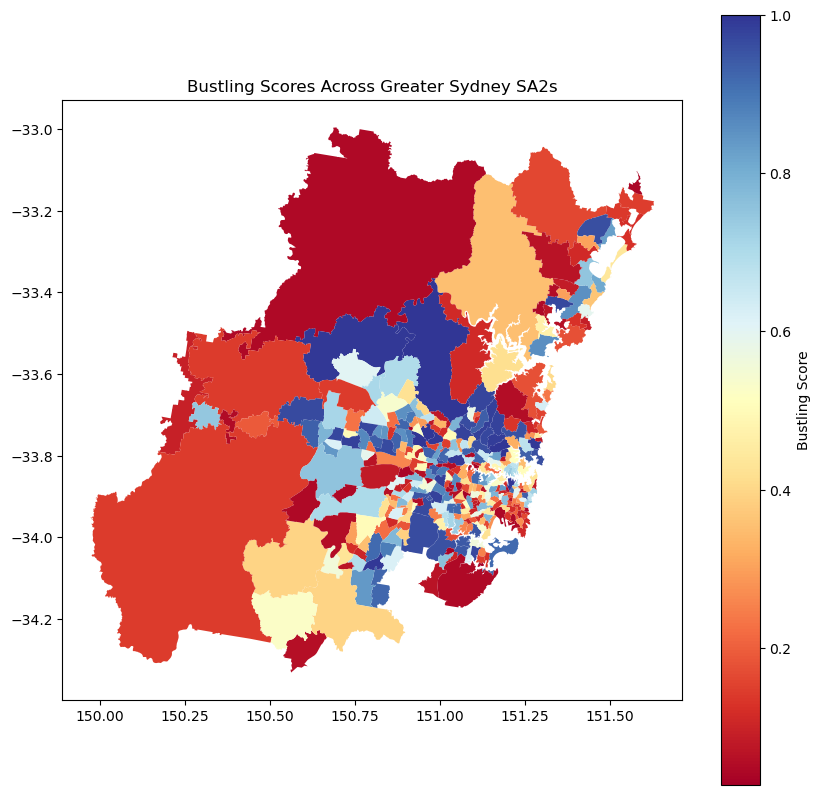

In [36]:
data = gpd.read_postgis("""
WITH businesses AS (
    WITH businesses_data AS (
        SELECT 
            businesses.sa2_code, 
            businesses.sa2_name, 
            sum(businesses.total_businesses) AS total_businesses,
            sa2.gcc_name21,
            sa2.geom,
            CASE 
                WHEN population.total_people = 0 THEN NULL
                ELSE population.total_people
            END AS total_people
        FROM 
            businesses
        JOIN 
            sa2 ON businesses.sa2_code = sa2.sa2_code21
        JOIN
            population ON businesses.sa2_code = population.sa2_code
        GROUP BY
            businesses.sa2_code, businesses.sa2_name, total_people, gcc_name21, geom
    )
    SELECT sa2_code, sa2_name, total_businesses, total_people,
        (total_businesses / 1000.0 * total_people) AS businesses_per_thousand,
        (total_businesses / 1000.0 * total_people - AVG(total_businesses / 1000.0 * total_people) OVER () ) / STDDEV(total_businesses / 1000.0 * total_people) OVER () AS z_score,
        geom
    FROM businesses_data
    WHERE gcc_name21 = 'Greater Sydney'
),

stops AS (
    SELECT sa2_code21, sa2_name21, count(stop_name) AS count,
        (count(stop_name) - AVG(count(stop_name)) OVER ()) / STDDEV(count(stop_name)) OVER () AS z_score,
        sa2.geom
    FROM stops
    JOIN sa2 on ST_CONTAINS(sa2.geom, stops.geom)
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),
    
pollingplaces2019 AS (
    SELECT sa2_code21, sa2_name21, count(polling_place_id), sa2.geom,
        (count(polling_place_name) - AVG(count(polling_place_name)) OVER ()) / STDDEV(count(polling_place_name)) OVER () AS z_score
    FROM pollingplaces2019
    JOIN sa2 ON ST_CONTAINS(sa2.geom, pollingplaces2019.geom)
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),

catchments AS (
    WITH catchments_data AS (
        SELECT 
            catchments.use_id,
            catchments.catch_type, 
            catchments.use_desc,
            catchments.school_type,
            catchments.geom AS catchments_geom,
            CASE
                WHEN population.young_people = 0 THEN NULL
                ELSE population.young_people
            END AS young_people,
            sa2.sa2_code21,
            sa2.sa2_name21,
            sa2.gcc_name21,
            sa2.geom AS sa2_geom
        FROM catchments
        JOIN sa2 ON ST_INTERSECTS(catchments.geom, sa2.geom)
        JOIN population ON(sa2_code21 = sa2_code)
    )
    SELECT sa2_code21, sa2_name21, count(use_id) AS catchments, young_people,
        (COUNT(use_id) / 1000.0 * young_people) AS catchments_per_thousand, 
        (COUNT(use_id) / 1000.0 * young_people - AVG(COUNT(use_id) / 1000.0 * young_people) OVER () ) / STDDEV(COUNT(use_id) / 1000.0 * young_people) OVER () AS z_score, 
        sa2_geom
    FROM catchments_data
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, young_people, sa2_geom
)
    
SELECT
    sa2_code, 
    sa2_name,
    1 / (1 + exp(-(
        COALESCE(businesses.z_score, 0) + 
        COALESCE(stops.z_score, 0) + 
        COALESCE(pollingplaces2019.z_score, 0) + 
        COALESCE(catchments.z_score, 0)
    ))) AS s_value, 
    sa2_geom
FROM businesses
LEFT JOIN stops ON (sa2_code = sa2_code21)
LEFT JOIN pollingplaces2019 USING(sa2_code21)
LEFT JOIN catchments USING(sa2_code21)
""", conn, geom_col = 'sa2_geom')

# map
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, column='s_value', cmap='RdYlBu', legend=True,legend_kwds = {'label': 'Bustling Score'})
plt.title("Bustling Scores Across Greater Sydney SA2s")
plt.show()

### With the addition of extra datasets

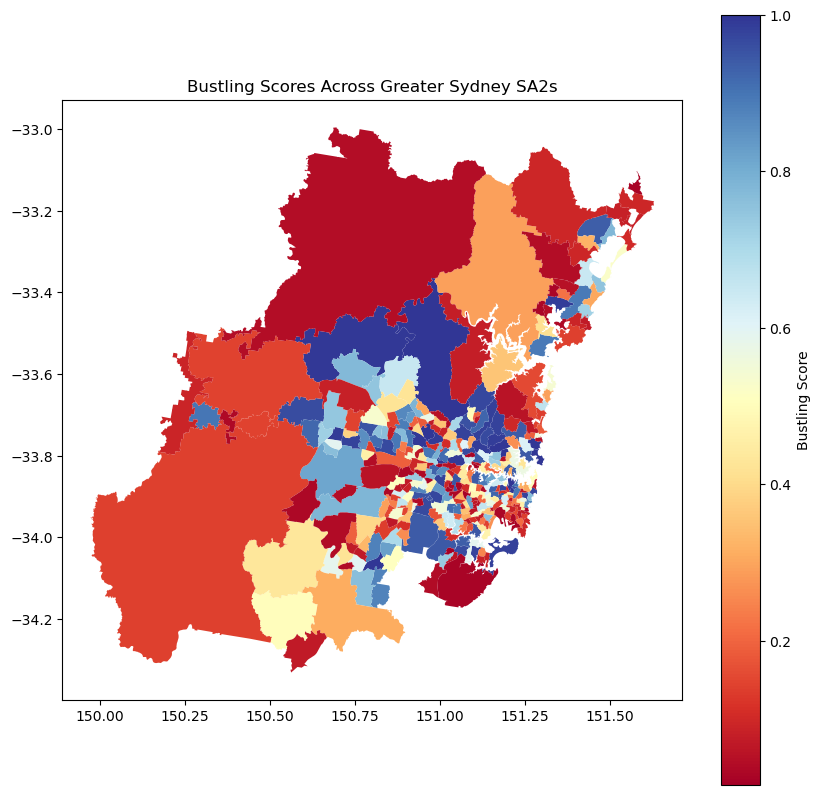

In [37]:
data = gpd.read_postgis("""
WITH businesses AS (
    WITH businesses_data AS (
        SELECT 
            businesses.sa2_code, 
            businesses.sa2_name, 
            sum(businesses.total_businesses) AS total_businesses,
            sa2.gcc_name21,
            sa2.geom,
            CASE 
                WHEN population.total_people = 0 THEN NULL
                ELSE population.total_people
            END AS total_people
        FROM 
            businesses
        JOIN 
            sa2 ON businesses.sa2_code = sa2.sa2_code21
        JOIN
            population ON businesses.sa2_code = population.sa2_code
        GROUP BY
            businesses.sa2_code, businesses.sa2_name, total_people, gcc_name21, geom
    )
    SELECT sa2_code, sa2_name, total_businesses, total_people,
        (total_businesses / 1000.0 * total_people) AS businesses_per_thousand,
        (total_businesses / 1000.0 * total_people - AVG(total_businesses / 1000.0 * total_people) OVER () ) / STDDEV(total_businesses / 1000.0 * total_people) OVER () AS z_score,
        geom
    FROM businesses_data
    WHERE gcc_name21 = 'Greater Sydney'
    ),

stops AS (
        SELECT sa2_code21, sa2_name21, count(stop_name) AS count,
             (count(stop_name) - AVG(count(stop_name)) OVER ()) / STDDEV(count(stop_name)) OVER () AS z_score,
             sa2.geom
        FROM stops
        JOIN sa2 on ST_CONTAINS(sa2.geom, stops.geom)
        GROUP BY sa2_code21, sa2_name21, sa2.geom
    ),
    
pollingplaces2019 AS (
    SELECT sa2_code21, sa2_name21, count(polling_place_id), sa2.geom,
        (count(polling_place_name) - AVG(count(polling_place_name)) OVER ()) / STDDEV(count(polling_place_name)) OVER () AS z_score
    FROM pollingplaces2019
    JOIN sa2 ON ST_CONTAINS(sa2.geom, pollingplaces2019.geom)
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, sa2.geom
),

catchments AS (
    WITH catchments_data AS (
        SELECT 
            catchments.use_id,
            catchments.catch_type, 
            catchments.use_desc,
            catchments.school_type,
            catchments.geom AS catchments_geom,
            CASE
                WHEN population.young_people = 0 THEN NULL
                ELSE population.young_people
            END AS young_people,
            sa2.sa2_code21,
            sa2.sa2_name21,
            sa2.gcc_name21,
            sa2.geom AS sa2_geom
        FROM catchments
        JOIN sa2 ON ST_INTERSECTS(catchments.geom, sa2.geom)
        JOIN population ON(sa2_code21 = sa2_code)
    )
    SELECT sa2_code21, sa2_name21, count(use_id) AS catchments, young_people,
        (COUNT(use_id) / 1000.0 * young_people) AS catchments_per_thousand, 
        (COUNT(use_id) / 1000.0 * young_people - AVG(COUNT(use_id) / 1000.0 * young_people) OVER () ) / STDDEV(COUNT(use_id) / 1000.0 * young_people) OVER () AS z_score, 
        sa2_geom
    FROM catchments_data
    WHERE gcc_name21 = 'Greater Sydney'
    GROUP BY sa2_code21, sa2_name21, young_people, sa2_geom
), 

alcohollicenses AS (
    SELECT sa2_code21, sa2_name21, count(license_no) AS licenses,
        (count(license_no) - AVG(count(license_no)) OVER ()) / STDDEV(count(license_no)) OVER () AS z_score, 
        sa2.geom
    FROM alcohollicenses
    JOIN sa2 ON st_contains(sa2.geom, alcohollicenses.geom)
    GROUP BY sa2_code21, sa2_name21, sa2.geom
), 

air_quality AS (
    SELECT sa2_name21,  sa2_code21, air_quality.value,
        (air_quality.value - AVG(air_quality.value) OVER ()) / STDDEV(air_quality.value) OVER () AS z_score, 
        sa2.geom
    FROM air_quality
    JOIN sa2 ON st_contains(sa2.geom, air_quality.geom)
)
    
SELECT
    sa2_code, 
    sa2_name,
    1 / (1 + exp(-(
        COALESCE(businesses.z_score, 0) + 
        COALESCE(stops.z_score, 0) + 
        COALESCE(pollingplaces2019.z_score, 0) + 
        COALESCE(catchments.z_score, 0) +
        COALESCE(alcohollicenses.z_score, 0) +
        COALESCE(air_quality.z_score, 0)
    ))) AS s_value, 
    sa2_geom
FROM businesses
LEFT JOIN stops ON (sa2_code = sa2_code21)
LEFT JOIN pollingplaces2019 USING(sa2_code21)
LEFT JOIN catchments USING(sa2_code21)
LEFT JOIN alcohollicenses USING(sa2_code21)
LEFT JOIN air_quality USING(sa2_code21)
ORDER BY s_value DESC
""", conn, geom_col = 'sa2_geom')

fig, ax = plt.subplots(figsize=(10, 10))
data.plot(ax=ax, column='s_value', cmap='RdYlBu', legend=True, legend_kwds = {'label': 'Bustling Score'})
plt.title("Bustling Scores Across Greater Sydney SA2s")
plt.show()

Text(0, 0.5, 'Number of SA2 Regions')

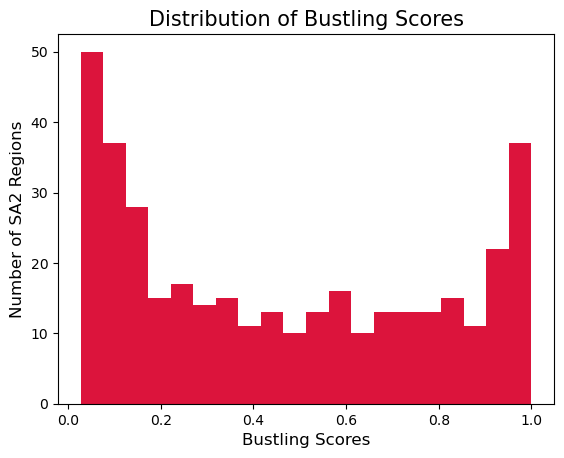

In [41]:
# histogram
plt.hist(corr.s_value, density=False, bins=20, label="Data", color = 'crimson')
plt.title("Distribution of Bustling Scores", fontsize=15)
plt.xlabel("Bustling Scores", fontsize=12)
plt.ylabel("Number of SA2 Regions", fontsize=12)


## Correlation analysis

In [64]:
corrg = gpd.read_postgis("""
WITH data AS (
    WITH businesses AS (
        WITH businesses_data AS (
            SELECT 
                businesses.sa2_code, 
                businesses.sa2_name, 
                sum(businesses.total_businesses) AS total_businesses,
                sa2.gcc_name21,
                sa2.geom,
                CASE 
                    WHEN population.total_people = 0 THEN NULL
                    ELSE population.total_people
                END AS total_people
            FROM 
                businesses
            JOIN 
                sa2 ON businesses.sa2_code = sa2.sa2_code21
            JOIN
                population ON businesses.sa2_code = population.sa2_code
            GROUP BY
                businesses.sa2_code, businesses.sa2_name, total_people, gcc_name21, geom
        )
        SELECT sa2_code, sa2_name, total_businesses, total_people,
            (total_businesses / 1000.0 * total_people) AS businesses_per_thousand,
            (total_businesses / 1000.0 * total_people - AVG(total_businesses / 1000.0 * total_people) OVER () ) / STDDEV(total_businesses / 1000.0 * total_people) OVER () AS z_score,
            geom
        FROM businesses_data
        WHERE gcc_name21 = 'Greater Sydney'
    ),

    stops AS (
        SELECT sa2_code21, sa2_name21, count(stop_name) AS count,
            (count(stop_name) - AVG(count(stop_name)) OVER ()) / STDDEV(count(stop_name)) OVER () AS z_score,
            sa2.geom
        FROM stops
        JOIN sa2 on ST_CONTAINS(sa2.geom, stops.geom)
        GROUP BY sa2_code21, sa2_name21, sa2.geom
    ),

    pollingplaces2019 AS (
        SELECT sa2_code21, sa2_name21, count(polling_place_id), sa2.geom,
            (count(polling_place_name) - AVG(count(polling_place_name)) OVER ()) / STDDEV(count(polling_place_name)) OVER () AS z_score
        FROM pollingplaces2019
        JOIN sa2 ON ST_CONTAINS(sa2.geom, pollingplaces2019.geom)
        WHERE gcc_name21 = 'Greater Sydney'
        GROUP BY sa2_code21, sa2_name21, sa2.geom
    ),

    catchments AS (
        WITH catchments_data AS (
            SELECT 
                catchments.use_id,
                catchments.catch_type, 
                catchments.use_desc,
                catchments.school_type,
                catchments.geom AS catchments_geom,
                CASE
                    WHEN population.young_people = 0 THEN NULL
                    ELSE population.young_people
                END AS young_people,
                sa2.sa2_code21,
                sa2.sa2_name21,
                sa2.gcc_name21,
                sa2.geom AS sa2_geom
            FROM catchments
            JOIN sa2 ON ST_INTERSECTS(catchments.geom, sa2.geom)
            JOIN population ON(sa2_code21 = sa2_code)
        )
        SELECT sa2_code21, sa2_name21, count(use_id) AS catchments, young_people,
            (COUNT(use_id) / 1000.0 * young_people) AS catchments_per_thousand, 
            (COUNT(use_id) / 1000.0 * young_people - AVG(COUNT(use_id) / 1000.0 * young_people) OVER () ) / STDDEV(COUNT(use_id) / 1000.0 * young_people) OVER () AS z_score, 
            sa2_geom
        FROM catchments_data
        WHERE gcc_name21 = 'Greater Sydney'
        GROUP BY sa2_code21, sa2_name21, young_people, sa2_geom
    ),
    
    income_z AS (
    SELECT sa2_code21, sa2_name, mean_income, median_income,
        (mean_income - AVG(mean_income) OVER ()) / STDDEV(mean_income) OVER () AS z_score_mean,
        (median_income - AVG(median_income) OVER ()) / STDDEV(median_income) OVER () AS z_score_median
    FROM income
    )

    SELECT
        b.sa2_code, 
        b.sa2_name,
        1 / (1 + exp(-(
            COALESCE(b.z_score, 0) + 
            COALESCE(s.z_score, 0) + 
            COALESCE(p.z_score, 0) + 
            COALESCE(c.z_score, 0)
        ))) AS s_value, 
        c.sa2_geom,
        i.z_score_mean,
        i.z_score_median,
        i.mean_income,
        i.median_income
    FROM businesses b
    LEFT JOIN stops s ON (b.sa2_code = s.sa2_code21)
    LEFT JOIN pollingplaces2019 p USING(sa2_code21)
    LEFT JOIN catchments c USING(sa2_code21)
    LEFT JOIN income_z i ON (b.sa2_code = i.sa2_code21
))

SELECT *
FROM data

""", conn, geom_col = 'sa2_geom')

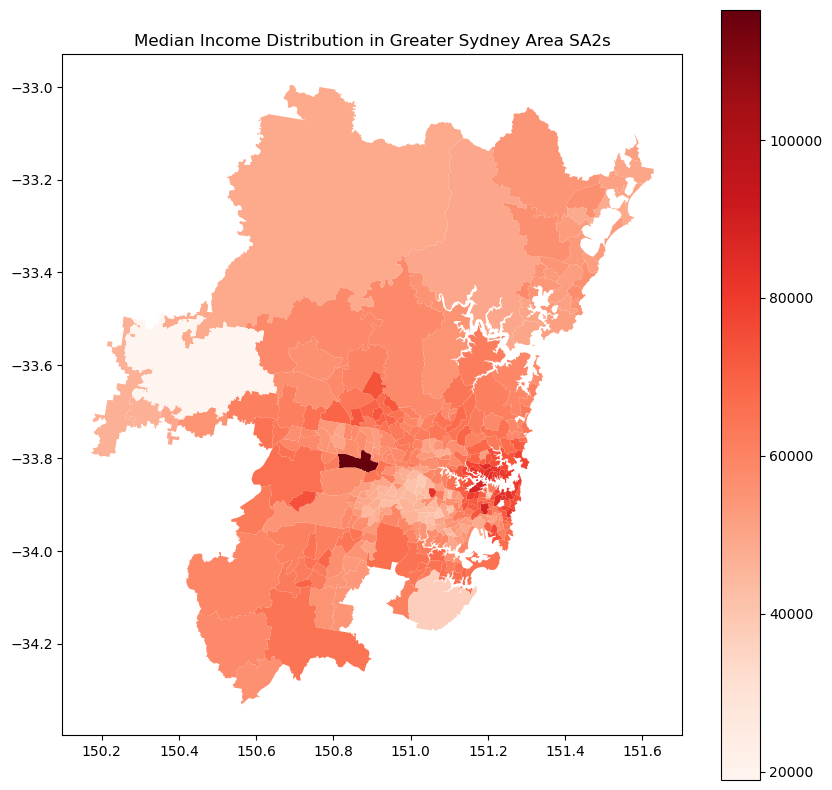

In [67]:
# create map for income distribution
fig, ax = plt.subplots(figsize=(10, 10))
corrg.plot(ax=ax, column='median_income', cmap='Reds', legend=True)
plt.title("Median Income Distribution in Greater Sydney Area SA2s")
plt.show()

0.02755470916795753

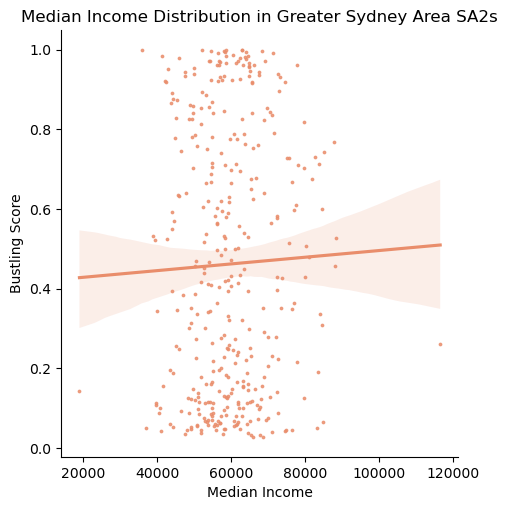

In [93]:
# colour
sns.set_palette(palette='flare')

#create linear model
plot = sns.lmplot(data=corrg,x="median_income", y="s_value", scatter_kws={"s": 3})
plt.title("Median Income Distribution in Greater Sydney Area SA2s")
plt.xlabel("Median Income")
plt.ylabel("Bustling Score")

# calculating the correlation coefficient

copy = corrg.dropna()
r, p = sp.stats.pearsonr(x=copy['median_income'], y=copy['s_value'])
r

Text(0, 0.5, '')

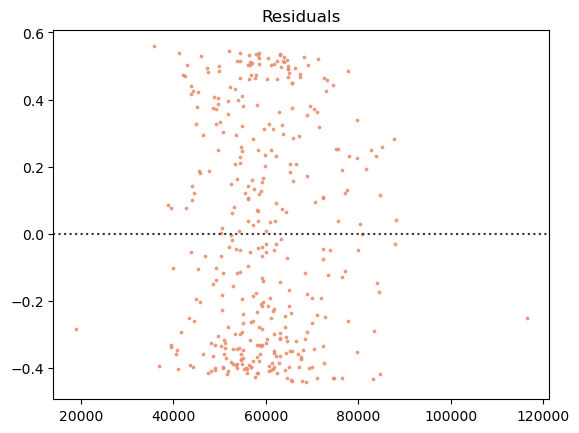

In [69]:
sns.residplot(data=corrg, x="median_income", y="s_value", scatter_kws={"s": 3})
plt.title("Residuals")
plt.xlabel("")
plt.ylabel("")